# Exercises

> **Note**: These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

## 0. Prerequisites

- Load libraries
- Load scripts
- Load data

In [4]:
# import libraries
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# try to get torchinfo
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

# try to import the going_modular directory and helper_functions sciprts
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    !git clone https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
    !mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/going_modular .
    !mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/helper_functions.py .
    !rm -rf PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'PyTorch-for-Deep-Learning-Machine-Learning-Full-Course'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 167 (delta 51), reused 66 (delta 27), pack-reused 56
Receiving objects: 100% (167/167), 50.09 MiB | 34.26 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [5]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
image_path = download_data(source='https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [9]:
from IPython.testing import test
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1ec43cca60>,
 ['pizza', 'steak', 'sushi'])

In [10]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

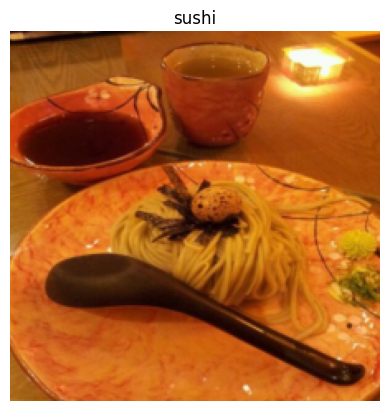

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers)

- You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
- You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1)

In [13]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 embedding_dropout: float=0.1,
                 d_model: int=768,
                 nhead: int=12,
                 dim_feedforward: int=3072,
                 activation: str="gelu",
                 dropout: float=0.1,
                 batch_first: bool=True,
                 norm_first: bool=True,
                 num_layers: int=12,
                 num_classes: int=1000
                 ):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.rand(1, self.num_patches + 1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=d_model,                  # Create a single transformer encoder
                                                                                                  nhead=nhead,
                                                                                                  dim_feedforward=dim_feedforward,
                                                                                                  activation=activation,
                                                                                                  dropout=dropout,
                                                                                                  batch_first=batch_first,
                                                                                                  norm_first=norm_first),
                                                        num_layers=num_layers)                                                      # stack the encoder N times
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    def forward(self, x):
        batch_size = x.shape[0]                                         # get the batch size from x
        class_token = self.class_embedding.expand(batch_size, -1, -1)   # expand the class token across the batch size
        x = self.patch_embedding(x)                                     # create the patch embedding
        x = torch.cat((class_token, x), dim=1)                          # prepend the class token to the patch embedding
        x = self.position_embedding + x                                 # add the position embedding to the patch embedding with class token
        x = self.embedding_dropout(x)                                   # apply dropout on patch + positional embedding
        x = self.transformer_encoder(x)                                 # pass embedding through transformer encoder stack
        x = self.classifier(x[:, 0])                                    # pass 0th index of x through MLP head
        return x

In [14]:
# test to see if the model is correct
summary(model=ViT(),
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`

- You should be able to import an entire ViT model using something like `from vit import ViT`.

In [15]:
%%writefile vit.py
import torch
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1)

class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 embedding_dropout: float=0.1,
                 d_model: int=768,
                 nhead: int=12,
                 dim_feedforward: int=3072,
                 activation: str="gelu",
                 dropout: float=0.1,
                 batch_first: bool=True,
                 norm_first: bool=True,
                 num_layers: int=12,
                 num_classes: int=1000
                 ):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.rand(1, self.num_patches + 1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=d_model,                  # Create a single transformer encoder
                                                                                                  nhead=nhead,
                                                                                                  dim_feedforward=dim_feedforward,
                                                                                                  activation=activation,
                                                                                                  dropout=dropout,
                                                                                                  batch_first=batch_first,
                                                                                                  norm_first=norm_first),
                                                        num_layers=num_layers)                                                      # stack the encoder N times
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    def forward(self, x):
        batch_size = x.shape[0]                                         # get the batch size from x
        class_token = self.class_embedding.expand(batch_size, -1, -1)   # expand the class token across the batch size
        x = self.patch_embedding(x)                                     # create the patch embedding
        x = torch.cat((class_token, x), dim=1)                          # prepend the class token to the patch embedding
        x = self.position_embedding + x                                 # add the position embedding to the patch embedding with class token
        x = self.embedding_dropout(x)                                   # apply dropout on patch + positional embedding
        x = self.transformer_encoder(x)                                 # pass embedding through transformer encoder stack
        x = self.classifier(x[:, 0])                                    # pass 0th index of x through MLP head
        return x

Writing vit.py


In [16]:
# test to see if the script works
from vit import ViT

imported_model = ViT()
summary(model=imported_model,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)

- See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [17]:
# get the pretrained weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# get the pretrained model
model = torchvision.models.vit_b_16(weights=weights).to(device)

# freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# change the classifier head
set_seeds()
model.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, out_features=len(class_names))
).to(device)
model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 95.7MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
# check the model layout
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [19]:
# get the 20% data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [20]:
# set directories
train_dir = data_20_percent_path / "train"
# test_dir = data_20_percent_path / "test"  # don't need 20% test data as the model in chapter 7 tests on 10% test data not 20% test data

# get pretrained model's transform
transforms = weights.transforms()

# turn data into dataloader
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                  test_dir=test_dir,
                                                                                  transform=transforms,
                                                                                  batch_size=32)

In [21]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)
# train a model
set_seeds()
results = engine.train(model=model,
                       train_dataloader=train_dataloader_20,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.6447 | Train acc: 0.7562 | Test loss: 0.2312 | Test acc: 0.9072
Epoch: 1 | Train loss: 0.2037 | Train acc: 0.9187 | Test loss: 0.2298 | Test acc: 0.9489
Epoch: 2 | Train loss: 0.1401 | Train acc: 0.9583 | Test loss: 0.1992 | Test acc: 0.9384
Epoch: 3 | Train loss: 0.1002 | Train acc: 0.9688 | Test loss: 0.1781 | Test acc: 0.9688
Epoch: 4 | Train loss: 0.0885 | Train acc: 0.9771 | Test loss: 0.1799 | Test acc: 0.9384
Epoch: 5 | Train loss: 0.0921 | Train acc: 0.9521 | Test loss: 0.1706 | Test acc: 0.9583
Epoch: 6 | Train loss: 0.0655 | Train acc: 0.9812 | Test loss: 0.1786 | Test acc: 0.9583
Epoch: 7 | Train loss: 0.0580 | Train acc: 0.9875 | Test loss: 0.1993 | Test acc: 0.9384
Epoch: 8 | Train loss: 0.0669 | Train acc: 0.9938 | Test loss: 0.2036 | Test acc: 0.9384
Epoch: 9 | Train loss: 0.0414 | Train acc: 0.9938 | Test loss: 0.1873 | Test acc: 0.9280


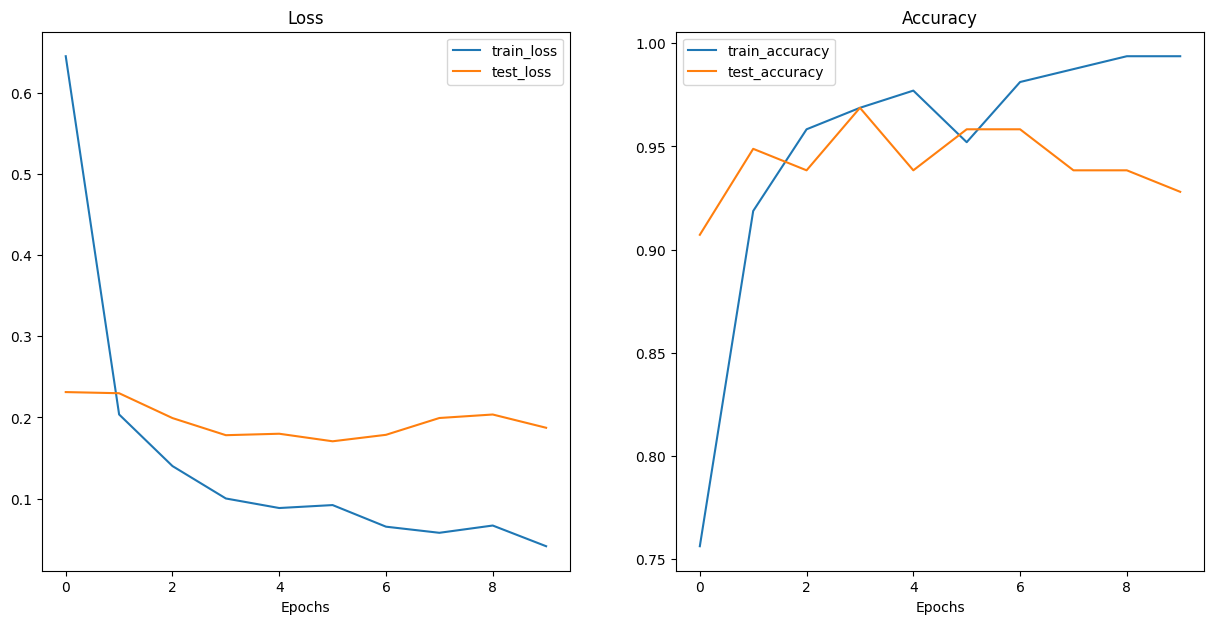

In [22]:
# examine results
plot_loss_curves(results)

Test loss is slightly better than EffNetB2 model, but the test accuracy is slightly lower

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)

- **Note**: ViT pretrained with SWAG weights has a minimum input image size of `(384, 384)` (the pretrained ViT in exercise 3 has a minimum input size of `(224, 224)`, though this is accessible in the weights `.transforms()` method.

In [23]:
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

model_2 = torchvision.models.vit_b_16(weights=weights).to(device)

for parameter in model_2.parameters():
    parameter.requires_grad = False

set_seeds()
model_2.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, out_features=len(class_names))
).to(device)
model_2

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:01<00:00, 245MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [24]:
# check the model layout
summary(model_2,
        input_size=(1, 3, 384, 384),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [25]:
# check transforms
weights.transforms()

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [26]:
# update the image size as IMAGENET1K_SWAG_E2E_V1 requires 384 instead of 224
# set directories
train_dir = data_20_percent_path / "train"
# test_dir = data_20_percent_path / "test"  # don't need 20% test data as the model in chapter 7 tests on 10% test data not 20% test data

# get pretrained model's transform
transforms = weights.transforms()

# turn data into dataloader
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                  test_dir=test_dir,
                                                                                  transform=transforms,
                                                                                  batch_size=32)

In [27]:
# re-assign loss function and optimizer to reflect the codes in exercise 4 instead of exercise 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=1e-3)

set_seeds()
results_2 = engine.train(model=model_2,
                         train_dataloader=train_dataloader_20,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         epochs=10,
                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4650 | Train acc: 0.9021 | Test loss: 0.0762 | Test acc: 0.9792
Epoch: 1 | Train loss: 0.0636 | Train acc: 0.9854 | Test loss: 0.0604 | Test acc: 0.9896
Epoch: 2 | Train loss: 0.0406 | Train acc: 0.9917 | Test loss: 0.0479 | Test acc: 0.9896
Epoch: 3 | Train loss: 0.0300 | Train acc: 0.9938 | Test loss: 0.0420 | Test acc: 0.9896
Epoch: 4 | Train loss: 0.0241 | Train acc: 0.9938 | Test loss: 0.0427 | Test acc: 0.9896
Epoch: 5 | Train loss: 0.0205 | Train acc: 0.9979 | Test loss: 0.0397 | Test acc: 0.9896
Epoch: 6 | Train loss: 0.0167 | Train acc: 0.9979 | Test loss: 0.0380 | Test acc: 0.9896
Epoch: 7 | Train loss: 0.0196 | Train acc: 0.9979 | Test loss: 0.0387 | Test acc: 0.9896
Epoch: 8 | Train loss: 0.0130 | Train acc: 1.0000 | Test loss: 0.0472 | Test acc: 0.9896
Epoch: 9 | Train loss: 0.0123 | Train acc: 0.9979 | Test loss: 0.0393 | Test acc: 0.9896


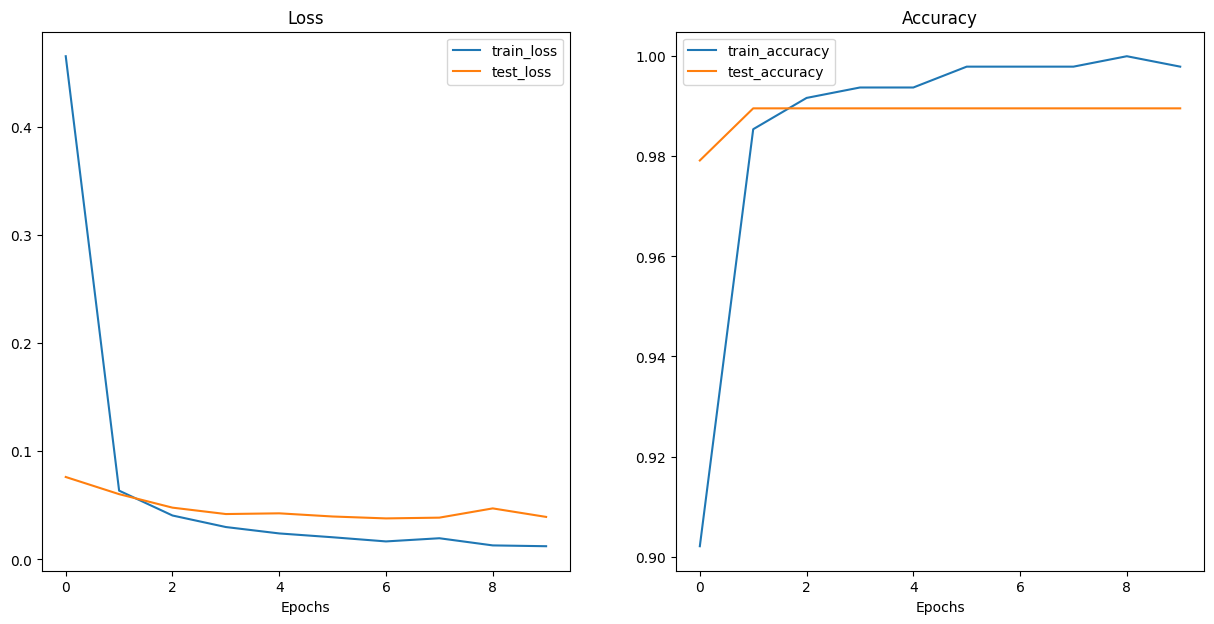

In [28]:
plot_loss_curves(results_2)

### Bonus: Get the "most wrong" examples from the test dataset

Since our ViT model trained with SWAG weights performed so well on the test dataset (close to 99% accuracy), let's see which samples it actually got wrong

In [29]:
# Get all test data paths
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        pred_dict = {}

        # Get sample path
        pred_dict["image_path"] = path

        # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Get prediction
        img = Image.open(path)                          # open image
        transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # Make sure things in the dictionary are back on the CPU
            pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict['pred_class'] = pred_class

        # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # Add the dictionary to the list of preds
        test_pred_list.append(pred_dict)

    return test_pred_list

In [30]:
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_2,
                                 transform=transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9994750618934631,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9994194507598877,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9994250535964966,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9998338222503662,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9993969202041626,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
  'class_name': 'sush

In [33]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

# How many samples from the test dataset did our model get correct?
test_pred_df.correct.value_counts()

True     74
False     1
Name: correct, dtype: int64

In [31]:
# Sort df by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
52,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.801234,steak,False
60,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,0.999948,pizza,True
51,data/pizza_steak_sushi/test/pizza/2111981.jpg,pizza,0.999943,pizza,True
56,data/pizza_steak_sushi/test/pizza/714866.jpg,pizza,0.999935,pizza,True
39,data/pizza_steak_sushi/test/steak/3424937.jpg,steak,0.999927,steak,True


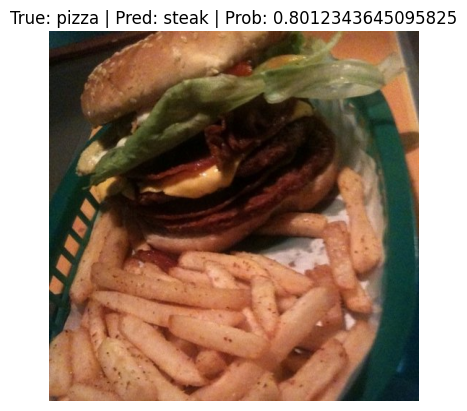

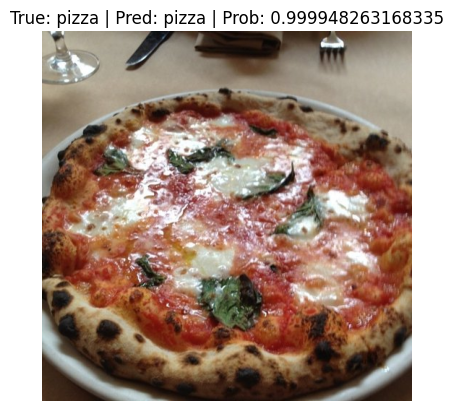

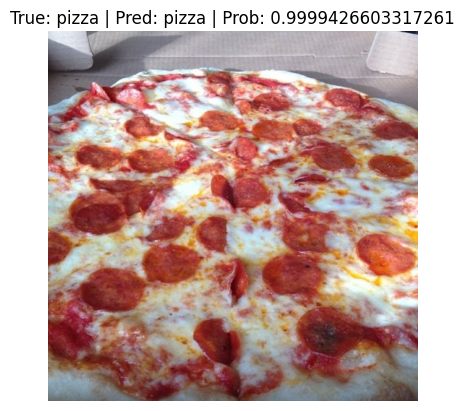

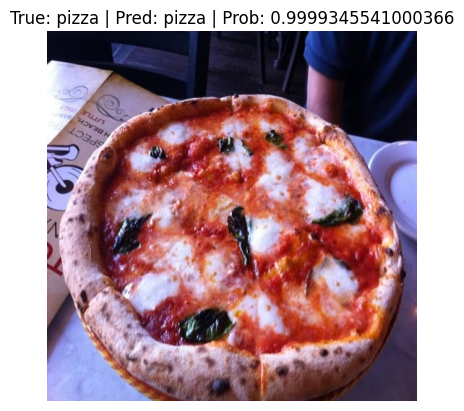

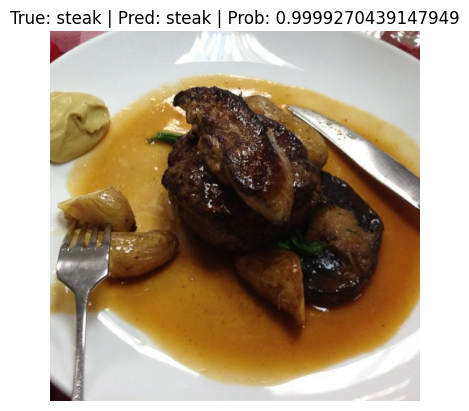

In [32]:
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]

    # Plot the image and various details
    img = torchvision.io.read_image(str(image_path))    # get image as tensor
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))                    # matplotlib likes images in [height, width, color_channels]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob}")
    plt.axis(False);

The wrong image was due to the wrong data in a test dataset image in test/pizza/2508636.jpg is a hamburger instead of a pizza

## 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:

- ImageNet-22k pretraining (more data).
- Learning rate warmup.
- Learning rate decay.
- Gradient clipping.

### ImageNet-22k pretraining

ImageNet-1k is a dataset of 1000 classes whereas ImageNet-22k is a dataset of 21841 classes

ImageNet-1k consists of 1.2 million images and ImageNet-22k consists of 14 million images

In simple terms, more data in more classes compared to ImageNet-1k

It can help to identify patterns since it's been trained on more data

If ImageNet-22k consists of more data in pizza, steak, and/or sushi (the classification problem we want to solve), then ImageNet-22k can be helpful. However, if the dataset doesn't contain more of the data we want (pizza, steak, and sushi), it won't be as helpful to training the model. The model can be good at classifying the categories overall, not define specific/limited categories to our problem

In [ ]:
# from hugging face
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

### Learning rate warmup

It is a heuristic process of setting the learning rate to a smaller value than of a desired learning rate at the beginning, then returning to a desired/initial learning rate (learning rate we wanted to set)

We know that the parameters/weights will have random values at the start of training, hence setting the learning rate small for the loss to head towards the global optimum to prevent unstability (at the beginning with the random values of weights, it can be unstable with the high learning rate)

Once we know that the training is stable (i.e. loss going down and accuracy going up instead of fluctuating), then go to a higher learning rate

It can help with our custom model as it's found to be used in various papers.

Also it will help find the right position at the beginning by moving slowly towards the global optimum. Once the direction is found, it will move towards that direction fast by increasing the learning rate.

### Learning rate decay

It's the opposite concept of the learning rate warmup, where we initialize a high learning rate at start, then reduce the learning rate after a few fixed points (e.g. ResNet, multiply LR by 0.1 after epochs 30, 60, and 90)

We know with a fixed high learning rate, we can reduce the loss fast, but it might miss the global optimum

With a fixed low learning rate, we can reduce the loss slow and find the global optimum, but can be time consuming

Therefore, setting a high learning rate at the begining to reduce the loss fast, then decrease the learning rate after certain points to head to global minimum

There are 5 different types of learning rate decay: step, cosine, linear, inverse square root, and constant

It can help with our model to find the global optimum due to setting different learning rates.

For code examples refer to below **Learning rate scheduler**

### Learning rate scheduler

[Sequential LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.SequentialLR.html#torch.optim.lr_scheduler.SequentialLR)

[Scheduling Optimizer](https://pytorch.org/docs/stable/optim.html)

[Blog (Korean)](https://gaussian37.github.io/dl-pytorch-lr_scheduler/)

Example 1:

In [ ]:
# Assuming optimizer uses lr = 1. for all groups
# lr = 0.1     if epoch == 0
# lr = 0.1     if epoch == 1
# lr = 0.9     if epoch == 2
# lr = 0.81    if epoch == 3
# lr = 0.729   if epoch == 4
opt = torch.optim.Adam(params=model_2.parameters(),
                       lr=1e-3)
scheduler1 = torch.optim.lr_scheduler.ConstantLR(opt, factor=0.1, total_iters=2)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
scheduler = torch.optim.lr_scheduler.SequentialLR(opt, schedulers=[scheduler1, scheduler2], milestones=[2])
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

Example 2:

`torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. [`torch.optim.lr_scheduler.ReduceLROnPlateau`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.

Learning rate scheduling should be applied after optimizer’s update; e.g., you should write your code this way:

In [36]:
# we need to apply this during training and validating our dataloder
# in our case, if added, it'll be located in the train() in going_modular/engine.py
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# example with train dataloader
for epoch in range(20):
    for input, target in train_dataloader_20:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_2(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()

# example with train and test dataloader
# for epoch in range(20):
#     train_step()          # train via train dataloader
#     test_step()           # test via test dataloader
#     scheduler.step()      # apply scheduler

Example 3:

Most learning rate schedulers can be called back-to-back (also referred to as chaining schedulers). The result is that each scheduler is applied one after the other on the learning rate obtained by the one preceding it.

In [ ]:
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

for epoch in range(20):
    for input, target in train_dataloader_20:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler1.step()
    scheduler2.step()

### Gradient clipping

It simply means clipping a gradint if it goes over the threshold

With clipping, it keeps the direction of the gradient vector, but moves at a lower amount for stability in oder to not miss the global optimum. With gradient exploding and large steps, the direction can be misguided.

This can help as well to keep the directiono the global minimum

[Gradient clipping](https://pytorch.org/docs/stable/nn.html?highlight=clip#torch.nn.utils.clip_grad_norm_)

Example:

In [ ]:
# In order to avoid gradient exploding, we apply gradient clipping
import torch

learning_rate = 1.
max_grad_norm = 5.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Gradient clipping in training phase
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
                               max_norm=max_grad_norm)
optimizer.step()